In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, roc_curve, auc

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, ConcatDataset, Subset, SubsetRandomSampler
from torchvision import transforms, datasets
import timm
import csv
import seaborn as sns
from sklearn.metrics import confusion_matrix
import copy
import random
from torch.optim.lr_scheduler import StepLR, MultiStepLR, LambdaLR, ExponentialLR, CosineAnnealingLR, ReduceLROnPlateau
from torchsummary import summary

In [3]:
# 设置随机数种子，保证结果的可重复性
random.seed(2024)
np.random.seed(2024)
torch.manual_seed(2024)
torch.cuda.manual_seed(2024)

In [5]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# nn.AdaptiveAvgPool1d
# Load pretrained Swin Transformer model
model = timm.create_model("swin_tiny_patch4_window7_224", pretrained=False, num_classes=2).to(device) # 构建模型，并修改成2分类问题
# print(model)
# for name, module in model.named_modules():
#     # if name == 'norm' or name == 'head':
#     print(name)
model
# summary(model, (3, 224, 224))

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): Sequential(
    (0): BasicLayer(
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU(approximate='none')
            (drop1)

In [5]:
# Load the pre-trained model's state dictionary
pretrained_model_path = "swin_tiny_patch4_window7_224_22k.pth" # swin_tiny_patch4_window7_224_22k.pth swin_tiny_patch4_window7_224_22kto1k_finetune.pth
pretrained_state_dict = torch.load(pretrained_model_path, map_location=torch.device('cuda'))['model']
# print(pretrained_state_dict)
# Print model structure
# for key in pretrained_state_dict.keys(): # 输出预训练模型的健
#     print(key)

# Change the output layer's weights and biases to match your model's output layer size
pretrained_state_dict['head.weight'] = pretrained_state_dict['head.weight'][:6, :]
pretrained_state_dict['head.bias'] = pretrained_state_dict['head.bias'][:6]

# Load the modified state dictionary into your model
model.load_state_dict(pretrained_state_dict)

<All keys matched successfully>

In [ ]:
# # 模型初始的dropout层p值为0，修改dropout层的p值，防止过拟合
# new_dropout = 0.0  # 设置为0.5，即50%的Dropout
# # 遍历模型的参数，找到所有的Dropout层，并设置新的Dropout值
# for name, module in model.named_modules():
#     if isinstance(module, nn.Dropout):
#         # print(name)
#         module.p = new_dropout
# model
# for name, module in model.named_modules():
#     # if name == 'norm' or name == 'head':
#     print(name)

In [6]:
all_layer_names = [name for name, _ in model.named_parameters()] # model.named_modules() model.named_parameters()
free_layer_names = all_layer_names[-20:]
free_layer_names

['layers.3.blocks.0.mlp.fc1.bias',
 'layers.3.blocks.0.mlp.fc2.weight',
 'layers.3.blocks.0.mlp.fc2.bias',
 'layers.3.blocks.1.norm1.weight',
 'layers.3.blocks.1.norm1.bias',
 'layers.3.blocks.1.attn.relative_position_bias_table',
 'layers.3.blocks.1.attn.qkv.weight',
 'layers.3.blocks.1.attn.qkv.bias',
 'layers.3.blocks.1.attn.proj.weight',
 'layers.3.blocks.1.attn.proj.bias',
 'layers.3.blocks.1.norm2.weight',
 'layers.3.blocks.1.norm2.bias',
 'layers.3.blocks.1.mlp.fc1.weight',
 'layers.3.blocks.1.mlp.fc1.bias',
 'layers.3.blocks.1.mlp.fc2.weight',
 'layers.3.blocks.1.mlp.fc2.bias',
 'norm.weight',
 'norm.bias',
 'head.weight',
 'head.bias']

In [7]:
import torch
from timm.models import create_model

num_params = sum(p.numel() for p in model.parameters()) # 模型的参数个数
print(f"Number of parameters in SwinTransformer model: {num_params}")


Number of parameters in SwinTransformer model: 27520892


In [8]:
# Data preprocessing and augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)), # 调整形状
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # 转成tensor格式
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# train_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     # transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
# ])

In [9]:

# transform = None
data_dir = "/root/autodl-tmp/project/MedSAM-0.1/data/MULTI_TUMOR_split" # 数据存储的根目录

train_data = datasets.ImageFolder(os.path.join(data_dir, "train")) # 对训练数据做增强，增加LGG类型的数量
# train_data = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform) # 不对训练数据做增强，使用focal loss解决不平衡问题
val_data = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform)
test_data = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform)

# train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
# train_data = train_loader.dataset[:1000]

# 从训练集中划分0.2作为验证集
# 划分训练集和验证集
# val_size = int(0.2 * len(train_data))
# train_size = len(train_data) - val_size

# val_size = 1000
# train_size = 6000
# other_size = len(train_data) - train_size - val_size
# print(train_size, val_size)
# train_data, val_data = random_split(train_data, [train_size, val_size])
# train_data, val_data, _ = random_split(train_data, [train_size, val_size, other_size]) # 训练数据集切分成训练集和验证集
# print(len(train_data))
batch_size=64
# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=64)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=64)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=64)

In [10]:
# 增加LGG的数量，因为训练中HGG与LGG的比例差不多为3.69:1
class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset, target_class, transform=None):
        self.original_dataset = original_dataset
        self.target_class = target_class
        self.transform = transform

        # 获取目标类别的图像索引
        self.target_indices = [index for index, (image, label) in enumerate(original_dataset) if label == target_class]
        self.num_target_samples = len(self.target_indices)
        print(len(original_dataset))
        print(self.num_target_samples)

    def __len__(self):
        return len(self.original_dataset) + 2 * self.num_target_samples

    def __getitem__(self, idx):
        if idx < len(self.original_dataset):
            image, label = self.original_dataset[idx]
            if self.transform:
                image = self.transform(image)
            return image, label
        elif idx >= len(self.original_dataset) and idx < (len(self.original_dataset) + self.num_target_samples): # 水平翻转增强
            # 随机选择一个目标类别的图像
            random_index = self.target_indices[idx - len(self.original_dataset)]
            image, label = self.original_dataset[random_index]
            # 对该图像进行随机水平翻转
            if self.transform:
                image = transforms.RandomHorizontalFlip()(image)
                image = self.transform(image)
            return image, label
        else: # 垂直翻转增强
            # 随机选择一个目标类别的图像
            random_index = self.target_indices[idx - len(self.original_dataset) - self.num_target_samples]
            image, label = self.original_dataset[random_index]
            # 对该图像进行随机垂直翻转
            if self.transform:
                image = transforms.RandomVerticalFlip()(image)
                image = self.transform(image)
            return image, label
# 定义要增强的目标类别
target_class = 0  # 假设要增强第1类的数据
# 构建增强后的数据集
augmented_dataset = AugmentedDataset(train_data, target_class, transform=transform) # 增加训练数据集中的hgg与lgg的比例
# 加载数据集
aug_train_data = DataLoader(augmented_dataset, batch_size=batch_size, shuffle=True)
train_loader = aug_train_data

11992
2558


In [11]:
len(train_data), len(val_data), len(test_data), len(augmented_dataset)
# len(train_data), len(test_data)

(11992, 3904, 4007, 17108)

In [12]:
# 加载dataset中的每一项，统计其中的0和1数量，构造出targets数组
targets = []
loader = DataLoader(augmented_dataset, batch_size=1, shuffle=False, num_workers=64)
for images, labels in loader:
    targets.append(labels.item())
    # print(labels)
    # break

In [13]:
targets.count(1), targets.count(0)

(9434, 7674)

In [70]:
# 

In [9]:
# 定义focal loss，解决数据不均衡的问题
import torch.nn.functional as F
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction # 损失函数的形式

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        # focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        focal_loss = (1-pt)**self.gamma * ce_loss
        # focal_loss.to(device)
        # print(focal_loss)
        
        # 给予不同类别不同的权重
        if self.alpha is not None:
            # print('hello')
            # print(targets)
            targets_cpu = targets.detach().cpu().numpy()
            # print(self.alpha.type())
            # print(inputs.data.type())
            # if self.alpha.type() != inputs.data.type():
                # self.alpha = self.alpha.type_as(inputs.data)
            alpha_factor = np.array(self.alpha)[targets_cpu]
            alpha_factor = torch.tensor(alpha_factor)
            alpha_factor = alpha_factor.to(device)
            # print(alpha_factor)
            focal_loss = alpha_factor * focal_loss
        
        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        else:
            return focal_loss

In [14]:
# 在次定义训练曲线绘制函数与混淆矩阵绘制函数
def plot_train_curve(modal ,train_acc_history, val_acc_history, val_auc_history, val_f1_history, val_r_history, val_fpr, val_tpr):
    # 传入的参数train acc; val acc; val auc; val f1; val r; val fpr; val tpr
    plt.figure()
    plt.plot(train_acc_history, label="Train Acc")
    plt.plot(val_acc_history, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig('./inde_train_curve_images/' + 'Acc_curve_of_' + modal + '.png') # 存储acc的训练曲线
    # plt.show()
    plt.close()

    plt.figure()
    plt.plot(val_auc_history, label="Val AUC")
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.legend()
    plt.savefig('./inde_train_curve_images/' + 'Auc_curve_of_' + modal + '.png') # 存储val auc的训练曲线
    # plt.show()
    plt.close()

    plt.figure()
    plt.plot(val_f1_history, label="Val F1")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.savefig('./inde_train_curve_images/' + 'F1_curve_of_' + modal + '.png') # 存储val f1的训练曲线
    # plt.show()
    plt.close()

    plt.figure()
    plt.plot(val_r_history, label="Val Recall")
    plt.xlabel("Epoch")
    plt.ylabel("Recall")
    plt.legend()
    plt.savefig('./inde_train_curve_images/' + 'Recall_curve_of_' + modal + '.png') # 存储val recall的训练曲线
    # plt.show()
    plt.close()
    
    plt.figure()
    plt.plot(val_fpr, val_tpr, label=f'ROC curve (area = {val_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('./inde_train_curve_images/' + 'ROC_curve_of_' + modal + '.png') # 存储ROC
    # plt.show()
    plt.close()

def plot_confusion_martix(kfold, y_true, y_pred): # 传入的是训练预测得到的标签与真实的标签
    # Define class labels
    labels = ['HGG','LGG']  # 用您的实际类别标签替换... LGG表示低级别胶质瘤，HGG表示高级别胶质瘤

    # Plot confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred)
    plt.figure()
    sns.heatmap(conf_mat, annot=True, fmt=".0f", cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")
    plt.savefig('./inde_val_confusion_martix_figs/' + 'Confusion_martix_of_' + modal + '.png')
    # plt.show()
    plt.close()

In [15]:
# Set loss function and optimizer
# 训练 验证 测试 基于scan划分，独立测试

# 迁移训练的层的设置
flair_model = copy.deepcopy(model) # 不同输入的模型结果需要分开存储
flair_model.to(device)
flair_params_to_update = [] # 需要更新的层

# 只更新部分层
for name, param in flair_model.named_parameters():
    # free后30层
    # if name.find("layers.3") == -1: # 当前层不含layer.3不更新权重
    #     param.requires_grad = False
    # if name.find("layers.3") == -1 and name not in ['norm.weight', 'norm.bias', 'head.weight', 'head.bias']: #  当前层不含layer.3且name不等于列表中的
    #     param.requires_grad = False
    # else: # 后30层网络需要训练
    #     param.requires_grad = True # 手动设置，不然不会自动赋值
    #     flair_params_to_update.append(param)  
    
    # free后2层
    # if name not in ['norm.weight', 'norm.bias', 'head.weight', 'head.bias']: # 只训练最后几层
    if name not in free_layer_names: # 只训练最后几层
        param.requires_grad = False 
    else:
        param.requires_grad = True # 手动设置，不然不会自动赋值
        flair_params_to_update.append(param)
        
        
# # 对需要更新的层，设置dropout防止过拟合
# new_dropout = 0.5  # 设置为0.5，即50%的Dropout
# # 遍历模型的参数，找到所有的Dropout层，并设置新的Dropout值
# for name, module in flair_model.named_modules():
#     # 修改后30层的dropout
#     if name.find("layers.3") == -1: # 当前层不含layer.3不更新权重
#         pass
#     if name.find("layers.3") == -1 and name not in ['norm.weight', 'norm.bias', 'head.weight', 'head.bias']: #  当前层不含layer.3且name不等于列表中的
#         pass
#     else: # 后30层网络需要训练
#         if isinstance(module, nn.Dropout):
#             # print(name)
#             module.p = new_dropout
# flair_model
len(flair_params_to_update)

20

In [16]:
criterion = nn.CrossEntropyLoss()
alpha = torch.tensor([3.0, 1.0])
# print(type(alpha))
# criterion = FocalLoss(alpha=[3.0, 1.0], gamma=2) # 自定义的focal loss
# criterion = nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-4)
optimizer = optim.Adam(flair_params_to_update, lr=1e-4)
# 学习率动态变化
# dynamic_lr = CosineAnnealingLR(optimizer, T_max=5)
# print("初始化的学习率：",optimizer.defaults['lr'])

# lr_list = []
# for epoch in range(1,101):
#     optimizer.zero_grad()
#     optimizer.step()
#     print("第%d个epoch的学习率：%f" % (epoch, optimizer.param_groups[0]['lr']))
#     lr_list.append(optimizer.param_groups[0]['lr'])
#     dynamic_lr.step()
    
# #画出epoch的变化图
# plt.plot(list(range(1,101)),lr_list)
# plt.xlabel("epoch")
# plt.ylabel("lr")
# plt.title("learning rate curve !")
# plt.show()

In [17]:
# Training and validation
num_epochs = 500
train_acc_history = []
val_acc_history = []
val_auc_history = []
val_f1_history = []
val_r_history = []

min_loss = float('inf') # 初始min_loss无穷大
best_acc = 0.0
best_auc = 0.0
patience = 30 # patience原来设成80，设为30当连续20个epoch不再下降时，改变学习率
early_stop = patience
change_rate = 15 # 多少个epoch不发生提升时，改变学习率

for epoch in range(num_epochs):
    # Training
    flair_model.train()
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device) # 图像与标签
        optimizer.zero_grad()
        outputs = flair_model(images)
        
        loss = criterion(outputs, labels) # 交叉熵损失函数集成了softmax，直接将模型的输出当成参数传入即可，不需要额外的softmax操作（否则报错）
        # print(loss)
        loss.backward()
        optimizer.step()


        # _, predicted = torch.max(outputs, 1)
        predicted = torch.argmax(outputs, 1) # argmax获得标签，用于计算acc等指标
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
    # 调整学习率, 一个epoch结束后调整学习率
    # print('current epoch lr:', optimizer.param_groups[0]['lr'])
    # dynamic_lr.step()
    lr = optimizer.param_groups[0]['lr'] # 当前epoch的学习率
    # 当early stop连续20次指标不再上升时，改变学习率
    if early_stop < (patience - change_rate):
        lr -= lr / (change_rate + early_stop)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        print ('Decay learning rate to lr: {}.'.format(lr))
    
    train_acc = train_correct / train_total
    train_acc_history.append(train_acc)

    
    # Validation
    flair_model.eval()
    val_correct = 0
    val_total = 0
    val_outputs_list = []
    val_labels_list = []
    val_loss = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = flair_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            # _, predicted = torch.max(outputs, 1)
            predicted = torch.argmax(outputs, 1)
    
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_outputs_list.append(outputs.cpu().numpy())
            val_labels_list.append(labels.cpu().numpy())

        val_acc = val_correct / val_total
        val_acc_history.append(val_acc)

        val_outputs = np.concatenate(val_outputs_list, axis=0)
        val_labels = np.concatenate(val_labels_list, axis=0)

        val_fpr, val_tpr, _ = roc_curve(val_labels, val_outputs[:, 1], pos_label=1) # 计算auc，val_outputs[:, 1]表示对正类别的预测概率
        val_auc = auc(val_fpr, val_tpr)
        val_auc_history.append(val_auc)

        val_f1 = f1_score(val_labels, np.argmax(val_outputs, axis=1),average='weighted')
        val_f1_history.append(val_f1)

        val_r = recall_score(val_labels, np.argmax(val_outputs, axis=1),average='weighted')
        val_r_history.append(val_r)

        # Calculate average validation loss
        avg_val_loss = val_loss / len(val_loader)
        # 得到验证集的平均损失
        # 设置早停点
        # if min_loss > avg_val_loss:
        if best_acc < val_acc: # 以auc值最大存储最佳模型
            # min_loss = avg_val_loss
            best_acc = val_acc
            early_stop = patience
            model_name = 'flair_model_c3.pth' # 损失值最小的时候设置成最佳模型
            torch.save(flair_model.state_dict(), model_name)
        else: # 当前的平均损失比之前epoch的要大
            early_stop -= 1
        
        # 当early_stop为0时，结束epoch训练
        if early_stop == 0:
            break

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}, Val F1: {val_f1:.4f}, Val Recall: {val_r:.4f}, Val Loss: {avg_val_loss:.4f}, Early Stop: {early_stop:.0f}")
        

plot_train_curve('flair', train_acc_history, val_acc_history, val_auc_history, val_f1_history, val_r_history, val_fpr, val_tpr)

Epoch 1/500, Train Acc: 0.8056, Val Acc: 0.8414, Val AUC: 0.9036, Val F1: 0.8456, Val Recall: 0.8414, Val Loss: 0.3653, Early Stop: 30
Epoch 2/500, Train Acc: 0.9498, Val Acc: 0.8468, Val AUC: 0.8976, Val F1: 0.8458, Val Recall: 0.8468, Val Loss: 0.4887, Early Stop: 30
Epoch 3/500, Train Acc: 0.9695, Val Acc: 0.8578, Val AUC: 0.9132, Val F1: 0.8553, Val Recall: 0.8578, Val Loss: 0.5067, Early Stop: 30
Epoch 4/500, Train Acc: 0.9761, Val Acc: 0.8404, Val AUC: 0.9052, Val F1: 0.8435, Val Recall: 0.8404, Val Loss: 0.5934, Early Stop: 29
Epoch 5/500, Train Acc: 0.9829, Val Acc: 0.8571, Val AUC: 0.9059, Val F1: 0.8540, Val Recall: 0.8571, Val Loss: 0.6330, Early Stop: 28
Epoch 6/500, Train Acc: 0.9839, Val Acc: 0.8320, Val AUC: 0.8924, Val F1: 0.8353, Val Recall: 0.8320, Val Loss: 0.7211, Early Stop: 27
Epoch 7/500, Train Acc: 0.9859, Val Acc: 0.8548, Val AUC: 0.8889, Val F1: 0.8525, Val Recall: 0.8548, Val Loss: 0.7324, Early Stop: 26
Epoch 8/500, Train Acc: 0.9878, Val Acc: 0.8599, Val AU

In [18]:
# torch.save(model.state_dict(), "swin_model_brat_cls_2024_4_21.pth") # 存储模型
flair_model.load_state_dict(torch.load("flair_model_c3.pth")) # 加载训练阶段存储的最佳模型

<All keys matched successfully>

In [19]:
# plot_train_curve('flair', train_acc_history, val_acc_history, val_auc_history, val_f1_history, val_r_history, val_fpr, val_tpr)

In [20]:
plot_train_curve('flair', train_acc_history, val_acc_history, val_auc_history, val_f1_history, val_r_history, val_fpr, val_tpr)

In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score, recall_score, roc_curve, auc

In [22]:
# Create a data loader for the images
import torch.nn.functional as F
data_dir = "/root/autodl-tmp/project/MedSAM-0.1/data/MULTI_TUMOR_split/test"
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_data = datasets.ImageFolder(data_dir, transform=transform)
data_loader = DataLoader(image_data, batch_size=1, shuffle=False)

# Predict and evaluate
y_true = []
y_pred = []
y_scores = []

with torch.no_grad():
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = flair_model(images)
        probabilities = F.softmax(outputs, dim=1)  # 使用softmax函数进行概率化处理
        _, predicted = torch.max(outputs, 1)
        y_true.append(labels.item())
        y_pred.append(predicted.item())
        y_scores.append(probabilities.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_scores = np.concatenate(y_scores, axis=0)

acc = accuracy_score(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_scores[:, 1], multi_class='ovo')
f1 = f1_score(y_true, y_pred,average='weighted')
recall = recall_score(y_true, y_pred,average='weighted')

print(f"Accuracy: {acc:.4f}, AUC: {auc_score:.4f}, F1 Score: {f1:.4f}, Recall: {recall:.4f}")

Accuracy: 0.8395, AUC: 0.8988, F1 Score: 0.8354, Recall: 0.8395


In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.72      0.62      0.66      1029
           1       0.87      0.92      0.89      2978

    accuracy                           0.84      4007
   macro avg       0.80      0.77      0.78      4007
weighted avg       0.83      0.84      0.84      4007



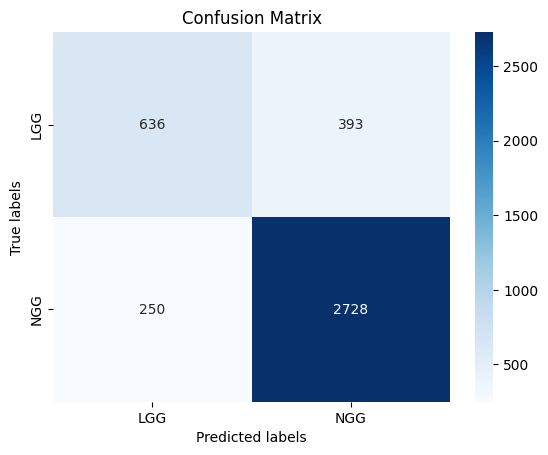

In [24]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Define class labels
labels = ['LGG','NGG']  # 用您的实际类别标签替换...

# Plot confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure()
sns.heatmap(conf_mat, annot=True, fmt=".0f", cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# 将模型训练和验证的方式改成交叉验证，解决数据不平衡时测试引入的误差
# 改成独立测试后，不运行以下代码
from sklearn.model_selection import StratifiedKFold

# Set loss function and optimizer
criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-4)
# optimizer = optim.Adam(model.parameters(), lr=1e-4)
batch_size = 64
# Training and validation
num_epochs = 500 # 预训练的基础上，可减少训练的epoch数

In [ ]:
# 使用交叉验证，不区分训练集和测试集
dataset = ConcatDataset([train_data, test_data])
# dataset, _ = random_split(dataset, [2000, len(dataset)-2000])

In [ ]:
# 加载dataset中的每一项，统计其中的0和1数量，构造出targets数组
targets = []
loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=64)
for images, labels in loader:
    targets.append(labels.item())
    # print(labels)
    # break

In [ ]:
len(targets)
# targets.count(0)
# targets.count(1)

In [ ]:
#跑t1 t1ce flair的

In [ ]:
# 在次定义训练曲线绘制函数与混淆矩阵绘制函数
def plot_train_curve(kfold ,train_acc_history, val_acc_history, val_auc_history, val_f1_history, val_r_history, val_fpr, val_tpr):
    # 传入的参数train acc; val acc; val auc; val f1; val r; val fpr; val tpr
    plt.figure()
    plt.plot(train_acc_history, label="Train Acc")
    plt.plot(val_acc_history, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig('./train_curve_images/' + 'Acc_curve_of_' + str(kfold) + '_fold_c3.png') # 存储acc的训练曲线
    # plt.show()
    plt.close()

    plt.figure()
    plt.plot(val_auc_history, label="Val AUC")
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.legend()
    plt.savefig('./train_curve_images/' + 'Auc_curve_of_' + str(kfold) + '_fold_c3.png') # 存储val auc的训练曲线
    # plt.show()
    plt.close()

    plt.figure()
    plt.plot(val_f1_history, label="Val F1")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.savefig('./train_curve_images/' + 'F1_curve_of_' + str(kfold) + '_fold_c3.png') # 存储val f1的训练曲线
    # plt.show()
    plt.close()

    plt.figure()
    plt.plot(val_r_history, label="Val Recall")
    plt.xlabel("Epoch")
    plt.ylabel("Recall")
    plt.legend()
    plt.savefig('./train_curve_images/' + 'Recall_curve_of_' + str(kfold) + '_fold_c3.png') # 存储val recall的训练曲线
    # plt.show()
    plt.close()
    
    plt.figure()
    plt.plot(val_fpr, val_tpr, label=f'ROC curve (area = {val_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('./train_curve_images/' + 'ROC_curve_of_' + str(kfold) + '_fold_c3.png') # 存储ROC
    # plt.show()
    plt.close()

def plot_confusion_martix(kfold, y_true, y_pred): # 传入的是训练预测得到的标签与真实的标签
    # Define class labels
    labels = ['HGG','LGG']  # 用您的实际类别标签替换... LGG表示低级别胶质瘤，HGG表示高级别胶质瘤

    # Plot confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred)
    plt.figure()
    sns.heatmap(conf_mat, annot=True, fmt=".0f", cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")
    plt.savefig('./val_confusion_martix_figs/' + 'Confusion_martix_of_' + str(kfold) + '_fold_c3.png')
    # plt.show()
    plt.close()

In [ ]:
final_acc_list = []
final_auc_list = []
final_f1_list = []
final_recall_list = []
# 新建一个excel表格。存储每折运行计算得到得指标
f = open('result_c3.csv', 'a', encoding='utf-8', newline='')
wr = csv.writer(f)
wr.writerow(['k-fold', 'Val Acc', 'Val AUC', 'Val F1', 'avg_fold_recall']) # csv的标题
k = 5 # 改成3折，增大验证的数据集
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=2024)
# for fold in range(k):
for fold, (train_indices, val_indices) in enumerate(skf.split(range(len(dataset)), targets)):
    print(f'Fold {fold + 1}/{k}')
    # train = [targets[i] for i in train_indices]
    # val = [targets[i] for i in val_indices]
    # print(type(train))
    # print(train.count(0))
    # print(train.count(1))
    # print('----')
    # print(val.count(0))
    # print(val.count(1))

    # print(fold) # 显示当前折的索引
    
    # 每一折分别记录训练时的指标变化，用于绘制训练曲线
    train_acc_history = []
    val_acc_history = []
    val_auc_history = []
    val_f1_history = []
    val_r_history = []
    # print(train_indices)
    # print('train length', len(train_indices))
    # print(val_indices)
    # print('val length', len(val_indices))
    # 获得训练和验证的索引之后
    # print(val_indices)
    # print(len(val_indices))
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    # avg_fold_acc = 0
    # avg_fold_auc = 0
    # avg_fold_f1 = 0
    # avg_fold_recall = 0
    # print(f"Fold {fold + 1}/{k}, Val Acc: {avg_fold_acc:.4f}, Val AUC: {avg_fold_auc:.4f}, Val F1: {avg_fold_f1:.4f}, avg_fold_recall: {avg_fold_recall:.4f}")

    # print(len(train_dataset), len(val_dataset))

    # print(f'Fold {fold + 1}/{k}')
    # train_sampler = SubsetRandomSampler(train_indices)
    # val_sampler = SubsetRandomSampler(val_indices)
    # dataset = dataset[:10]
    
    # kfold_model = model # 每折的模型要重置
    # 模型重置的时候需要使用深拷贝，不能直接使用赋值语句
    kfold_model = copy.deepcopy(model)
    kfold_model.to(device)
    params_to_update_kfold_model = [] # 对拷贝后的模型，也只更新最后几层
    for name, param in kfold_model.named_parameters():
        # if name not in ['norm.weight', 'norm.bias', 'head.weight', 'head.bias']: # 只训练最后几层
        #     param.requires_grad = False 
        # else:
        #     param.requires_grad = True # 手动设置，不然不会自动赋值
        #     params_to_update_kfold_model.append(param)
        
        # 冻结倒数前30层
        if name.find("layers.3") == -1: # 当前层不含layer.3不更新权重
            param.requires_grad = False
        if name.find("layers.3") == -1 and name not in ['norm.weight', 'norm.bias', 'head.weight', 'head.bias']: #  当前层不含layer.3且name不等于列表中的
            param.requires_grad = False
        else: # 后30层网络需要训练
            param.requires_grad = True # 手动设置，不然不会自动赋值
            params_to_update_kfold_model.append(param)
        
        # # 冻结倒数前4层
        # if name not in ['norm.weight', 'norm.bias', 'head.weight', 'head.bias', 'layers.3.blocks.1.mlp.fc1.weight', 'layers.3.blocks.1.mlp.fc1.bias', 'layers.3.blocks.1.mlp.fc2.weight', 'layers.3.blocks.1.mlp.fc2.bias']: # 只训练最后几层
        #     param.requires_grad = False 
        # else:
        #     param.requires_grad = True # 手动设置，不然不会自动赋值
        #     params_to_update_kfold_model.append(param)
    # print(len(params_to_update_kfold_model))
    # 冻结某些层后，修改optimizer，只更新未冻结的层
    optimizer = optim.Adam(params_to_update_kfold_model, lr=1e-4)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=64)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=64)    
    
    epochs_acc_list = []
    epochs_auc_list = []
    epochs_f1_list = []
    epochs_recall_list = []
    best_acc = 0.
    best_auc = 0.
    best_f1 = 0.
    best_recall = 0.
    
    # 早停点
    min_loss = float('inf') # 初始min_loss无穷大
    patience = 20
    early_stop = patience
    
    for epoch in range(num_epochs):
        # Training
        kfold_model.train()
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device) # 图像与标签
            # print(labels)
            # break

            optimizer.zero_grad()
            # outputs = model(images)
            outputs = kfold_model(images)

            loss = criterion(outputs, labels) # 交叉熵损失函数集成了softmax，直接将模型的输出当成参数传入即可，不需要额外的softmax操作（否则报错）
            loss.backward()
            optimizer.step()

            # _, predicted = torch.max(outputs, 1)
            predicted = torch.argmax(outputs, 1) # argmax获得标签，用于计算acc等指标
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_acc = train_correct / train_total
        train_acc_history.append(train_acc)


            # Validation
        kfold_model.eval()
        val_correct = 0
        val_total = 0
        val_outputs_list = []
        val_labels_list = []
        y_pred_list = [] # 存储预测的标签
        val_loss = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                # outputs = model(images)
                outputs = kfold_model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # _, predicted = torch.max(outputs, 1)
                predicted = torch.argmax(outputs, 1)

                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_outputs_list.append(outputs.cpu().numpy())
                y_pred_list.append(predicted.cpu().numpy())
                val_labels_list.append(labels.cpu().numpy())

            val_acc = val_correct / val_total
            val_acc_history.append(val_acc)

            val_outputs = np.concatenate(val_outputs_list, axis=0)
            y_pred = np.concatenate(y_pred_list, axis=0)
            val_labels = np.concatenate(val_labels_list, axis=0)
            # y_true = np.array(y_true)
            # y_pred = np.array(y_pred)
            # print(predicted)
            # print(y_pred)
            # print(val_labels)
            # break
            

            val_fpr, val_tpr, _ = roc_curve(val_labels, val_outputs[:, 1], pos_label=1) # 计算auc，val_outputs[:, 1]表示对正类别的预测概率
            val_auc = auc(val_fpr, val_tpr)
            val_auc_history.append(val_auc)

            val_f1 = f1_score(val_labels, np.argmax(val_outputs, axis=1),average='weighted')
            val_f1_history.append(val_f1)

            val_r = recall_score(val_labels, np.argmax(val_outputs, axis=1),average='weighted')
            val_r_history.append(val_r)

            # Calculate average validation loss
            avg_val_loss = val_loss / len(val_loader)
            # 得到验证集的平均损失
            # 设置早停点
            if min_loss > avg_val_loss:
                min_loss = avg_val_loss
                early_stop = patience
                
                # 验证集损失小的时候指标的值设为最佳
                best_acc = val_acc
                best_auc = val_auc
                best_f1 = val_f1
                best_recall = val_r
                model_name = 'kfold_' + str(fold+1) + '_model_c3.pth'
                torch.save(kfold_model.state_dict(), model_name)
                # 在存储最佳模型的同时，利用最佳模型的结果，绘制该折的混淆矩阵
                plot_confusion_martix(fold + 1, val_labels, y_pred)
            else: # 当前的平均损失比之前epoch的要大
                early_stop -= 1

            # 当early_stop为0时，结束epoch训练
            if early_stop == 0:
                break

            print(f"Epoch {epoch + 1}/{num_epochs}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}, Val F1: {val_f1:.4f}, Val Recall: {val_r:.4f}, Val Loss: {avg_val_loss:.4f}, Early Stop: {early_stop:.0f}")
            epochs_acc_list.append(val_acc)
            epochs_auc_list.append(val_auc)
            epochs_f1_list.append(val_f1)
            epochs_recall_list.append(val_r)
            # 每个epoch验证完成之后，存储验证性能最佳的
            # 依据recall的值进行选择，选取此时的指标最为最佳，并存储此时的模型
            # if val_auc > best_auc:
            #     best_acc = val_acc
            #     best_auc = val_auc
            #     best_f1 = val_f1
            #     best_recall = val_r
            #     model_name = 'kfold_' + str(fold+1) + '_model.pth'
            #     torch.save(kfold_model.state_dict(), model_name)
            #     # 在存储最佳模型的同时，利用最佳模型的结果，绘制该折的混淆矩阵
            #     plot_confusion_martix(fold + 1, val_labels, y_pred)
            
    # 记录验证集的各项指标作为对模型评价的结果
    # 不同折训练100个epoch后，计算得到验证的各指标的均值，每一折验证的性能选指标最佳的
    # avg_fold_acc = np.mean(epochs_acc_list)
    # avg_fold_auc = np.mean(epochs_auc_list)
    # avg_fold_f1 = np.mean(epochs_f1_list)
    # avg_fold_recall = np.mean(epochs_recall_list)
    
    # 每一折获得的平均值存储起来
    final_acc_list.append(best_acc)
    final_auc_list.append(best_auc)
    final_f1_list.append(best_f1)
    final_recall_list.append(best_recall)
    # avg_fold_acc = 0
    # avg_fold_auc = 0
    # avg_fold_f1 = 0
    # val_r = 0
    wr.writerow([fold + 1, best_acc, best_auc, best_f1, best_recall])
    print(f"Fold {fold + 1}/{k}, Val Acc: {best_acc:.4f}, Val AUC: {best_auc:.4f}, Val F1: {best_f1:.4f}, avg_fold_recall: {best_recall:.4f}")
    # 绘制训练曲线
    plot_train_curve(fold + 1, train_acc_history, val_acc_history, val_auc_history, val_f1_history, val_r_history, val_fpr, val_tpr)
    
f.close()

In [ ]:
acc = np.mean(final_acc_list)
auc_score = np.mean(final_auc_list)
f1 = np.mean(final_f1_list)
recall = np.mean(final_recall_list)
print(f"Accuracy: {acc:.4f}, AUC: {auc_score:.4f}, F1 Score: {f1:.4f}, Recall: {recall:.4f}")

In [ ]:
# 跑单T1输入的

In [ ]:

data_dir = "/root/autodl-tmp/project/MedSAM-0.1/data/classfication_t1_data" # 数据存储的根目录
train_data = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform)
test_data = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform)

# 使用交叉验证，不区分训练集和测试集
dataset = ConcatDataset([train_data, test_data])
# 加载dataset中的每一项，统计其中的0和1数量，构造出targets数组
targets = []
loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=64)
for images, labels in loader:
    targets.append(labels.item())

# 在次定义训练曲线绘制函数与混淆矩阵绘制函数
def plot_train_curve(kfold ,train_acc_history, val_acc_history, val_auc_history, val_f1_history, val_r_history, val_fpr, val_tpr):
    # 传入的参数train acc; val acc; val auc; val f1; val r; val fpr; val tpr
    plt.figure()
    plt.plot(train_acc_history, label="Train Acc")
    plt.plot(val_acc_history, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig('./train_curve_images/' + 'Acc_curve_of_' + str(kfold) + '_fold_T1.png') # 存储acc的训练曲线
    # plt.show()
    plt.close()

    plt.figure()
    plt.plot(val_auc_history, label="Val AUC")
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.legend()
    plt.savefig('./train_curve_images/' + 'Auc_curve_of_' + str(kfold) + '_fold_T1.png') # 存储val auc的训练曲线
    # plt.show()
    plt.close()

    plt.figure()
    plt.plot(val_f1_history, label="Val F1")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.savefig('./train_curve_images/' + 'F1_curve_of_' + str(kfold) + '_fold_T1.png') # 存储val f1的训练曲线
    # plt.show()
    plt.close()

    plt.figure()
    plt.plot(val_r_history, label="Val Recall")
    plt.xlabel("Epoch")
    plt.ylabel("Recall")
    plt.legend()
    plt.savefig('./train_curve_images/' + 'Recall_curve_of_' + str(kfold) + '_fold_T1.png') # 存储val recall的训练曲线
    # plt.show()
    plt.close()
    
    plt.figure()
    plt.plot(val_fpr, val_tpr, label=f'ROC curve (area = {val_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('./train_curve_images/' + 'ROC_curve_of_' + str(kfold) + '_fold_T1.png') # 存储ROC
    # plt.show()
    plt.close()

def plot_confusion_martix(kfold, y_true, y_pred): # 传入的是训练预测得到的标签与真实的标签
    # Define class labels
    labels = ['HGG','LGG']  # 用您的实际类别标签替换... LGG表示低级别胶质瘤，HGG表示高级别胶质瘤

    # Plot confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred)
    plt.figure()
    sns.heatmap(conf_mat, annot=True, fmt=".0f", cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")
    plt.savefig('./val_confusion_martix_figs/' + 'Confusion_martix_of_' + str(kfold) + '_fold_T1.png')
    # plt.show()
    plt.close()

In [ ]:
final_acc_list = []
final_auc_list = []
final_f1_list = []
final_recall_list = []
# 新建一个excel表格。存储每折运行计算得到得指标
f = open('result_T1.csv', 'a', encoding='utf-8', newline='')
wr = csv.writer(f)
wr.writerow(['k-fold', 'Val Acc', 'Val AUC', 'Val F1', 'avg_fold_recall']) # csv的标题
k = 5 # 改成3折，增大验证的数据集
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=2024)
# for fold in range(k):
for fold, (train_indices, val_indices) in enumerate(skf.split(range(len(dataset)), targets)):
    print(f'Fold {fold + 1}/{k}')
    
    # 每一折分别记录训练时的指标变化，用于绘制训练曲线
    train_acc_history = []
    val_acc_history = []
    val_auc_history = []
    val_f1_history = []
    val_r_history = []

    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    
    # kfold_model = model # 每折的模型要重置
    # 模型重置的时候需要使用深拷贝，不能直接使用赋值语句
    kfold_model = copy.deepcopy(model)
    kfold_model.to(device)
    params_to_update_kfold_model = [] # 对拷贝后的模型，也只更新最后几层
    for name, param in kfold_model.named_parameters():
        # if name not in ['norm.weight', 'norm.bias', 'head.weight', 'head.bias']: # 只训练最后几层
        #     param.requires_grad = False 
        # else:
        #     param.requires_grad = True # 手动设置，不然不会自动赋值
        #     params_to_update_kfold_model.append(param)

        # 冻结倒数前30层
        if name.find("layers.3") == -1: # 当前层不含layer.3不更新权重
            param.requires_grad = False
        if name.find("layers.3") == -1 and name not in ['norm.weight', 'norm.bias', 'head.weight', 'head.bias']: #  当前层不含layer.3且name不等于列表中的
            param.requires_grad = False
        else: # 后30层网络需要训练
            param.requires_grad = True # 手动设置，不然不会自动赋值
            params_to_update_kfold_model.append(param)

        # print(name)
    
    # 冻结某些层后，修改optimizer，只更新未冻结的层
    optimizer = optim.Adam(params_to_update_kfold_model, lr=1e-4)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=64)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=64)    
    
    epochs_acc_list = []
    epochs_auc_list = []
    epochs_f1_list = []
    epochs_recall_list = []
    best_acc = 0.
    best_auc = 0.
    best_f1 = 0.
    best_recall = 0.

    # 早停点
    min_loss = float('inf') # 初始min_loss无穷大
    patience = 20
    early_stop = patience
    
    for epoch in range(num_epochs):
        # Training
        kfold_model.train()
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device) # 图像与标签
            # print(labels)
            # break

            optimizer.zero_grad()
            # outputs = model(images)
            outputs = kfold_model(images)

            loss = criterion(outputs, labels) # 交叉熵损失函数集成了softmax，直接将模型的输出当成参数传入即可，不需要额外的softmax操作（否则报错）
            loss.backward()
            optimizer.step()

            # _, predicted = torch.max(outputs, 1)
            predicted = torch.argmax(outputs, 1) # argmax获得标签，用于计算acc等指标
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_acc = train_correct / train_total
        train_acc_history.append(train_acc)


            # Validation
        kfold_model.eval()
        val_correct = 0
        val_total = 0
        val_outputs_list = []
        val_labels_list = []
        y_pred_list = [] # 存储预测的标签
        val_loss = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                # outputs = model(images)
                outputs = kfold_model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # _, predicted = torch.max(outputs, 1)
                predicted = torch.argmax(outputs, 1)

                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_outputs_list.append(outputs.cpu().numpy())
                y_pred_list.append(predicted.cpu().numpy())
                val_labels_list.append(labels.cpu().numpy())

            val_acc = val_correct / val_total
            val_acc_history.append(val_acc)

            val_outputs = np.concatenate(val_outputs_list, axis=0)
            y_pred = np.concatenate(y_pred_list, axis=0)
            val_labels = np.concatenate(val_labels_list, axis=0)
            # y_true = np.array(y_true)
            # y_pred = np.array(y_pred)
            # print(predicted)
            # print(y_pred)
            # print(val_labels)
            # break
            

            val_fpr, val_tpr, _ = roc_curve(val_labels, val_outputs[:, 1], pos_label=1) # 计算auc，val_outputs[:, 1]表示对正类别的预测概率
            val_auc = auc(val_fpr, val_tpr)
            val_auc_history.append(val_auc)

            val_f1 = f1_score(val_labels, np.argmax(val_outputs, axis=1),average='weighted')
            val_f1_history.append(val_f1)

            val_r = recall_score(val_labels, np.argmax(val_outputs, axis=1),average='weighted')
            val_r_history.append(val_r)

            # Calculate average validation loss
            avg_val_loss = val_loss / len(val_loader)
            
            if min_loss > avg_val_loss:
                min_loss = avg_val_loss
                early_stop = patience
                
                # 验证集损失小的时候指标的值设为最佳
                best_acc = val_acc
                best_auc = val_auc
                best_f1 = val_f1
                best_recall = val_r
                model_name = 'kfold_' + str(fold+1) + '_model_T1.pth'
                torch.save(kfold_model.state_dict(), model_name)
                # 在存储最佳模型的同时，利用最佳模型的结果，绘制该折的混淆矩阵
                plot_confusion_martix(fold + 1, val_labels, y_pred)
            else: # 当前的平均损失比之前epoch的要大
                early_stop -= 1

            # 当early_stop为0时，结束epoch训练
            if early_stop == 0:
                break

            print(f"Epoch {epoch + 1}/{num_epochs}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}, Val F1: {val_f1:.4f}, Val Recall: {val_r:.4f}, Val Loss: {avg_val_loss:.4f}, Early Stop: {early_stop:.0f}")
   
            # print(f"Epoch {epoch + 1}/{num_epochs}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}, Val F1: {val_f1:.4f}, Val Recall: {val_r:.4f}, Val Loss: {avg_val_loss:.4f}")
            epochs_acc_list.append(val_acc)
            epochs_auc_list.append(val_auc)
            epochs_f1_list.append(val_f1)
            epochs_recall_list.append(val_r)
            # 每个epoch验证完成之后，存储验证性能最佳的
            # 依据recall的值进行选择，选取此时的指标最为最佳，并存储此时的模型
            # if val_auc > best_auc:
            #     best_acc = val_acc
            #     best_auc = val_auc
            #     best_f1 = val_f1
            #     best_recall = val_r
            #     model_name = 'kfold_' + str(fold+1) + '_model_T1.pth'
            #     torch.save(kfold_model.state_dict(), model_name)
            #     # 在存储最佳模型的同时，利用最佳模型的结果，绘制该折的混淆矩阵
            #     plot_confusion_martix(fold + 1, val_labels, y_pred)
            
    # 记录验证集的各项指标作为对模型评价的结果
    # 不同折训练100个epoch后，计算得到验证的各指标的均值，每一折验证的性能选指标最佳的
    # avg_fold_acc = np.mean(epochs_acc_list)
    # avg_fold_auc = np.mean(epochs_auc_list)
    # avg_fold_f1 = np.mean(epochs_f1_list)
    # avg_fold_recall = np.mean(epochs_recall_list)
    
    # 每一折获得的平均值存储起来
    final_acc_list.append(best_acc)
    final_auc_list.append(best_auc)
    final_f1_list.append(best_f1)
    final_recall_list.append(best_recall)
    # avg_fold_acc = 0
    # avg_fold_auc = 0
    # avg_fold_f1 = 0
    # val_r = 0
    wr.writerow([fold + 1, best_acc, best_auc, best_f1, best_recall])
    print(f"Fold {fold + 1}/{k}, Val Acc: {best_acc:.4f}, Val AUC: {best_auc:.4f}, Val F1: {best_f1:.4f}, avg_fold_recall: {best_recall:.4f}")
    # 绘制训练曲线
    plot_train_curve(fold + 1, train_acc_history, val_acc_history, val_auc_history, val_f1_history, val_r_history, val_fpr, val_tpr)
    
f.close()

In [ ]:
acc = np.mean(final_acc_list)
auc_score = np.mean(final_auc_list)
f1 = np.mean(final_f1_list)
recall = np.mean(final_recall_list)
print(f"T1: Accuracy: {acc:.4f}, AUC: {auc_score:.4f}, F1 Score: {f1:.4f}, Recall: {recall:.4f}")

In [ ]:
# 单flair作为输入

In [ ]:

data_dir = "/root/autodl-tmp/project/MedSAM-0.1/data/classfication_data_copy" # 数据存储的根目录
train_data = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform)
test_data = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform)

# 使用交叉验证，不区分训练集和测试集
dataset = ConcatDataset([train_data, test_data])
# 加载dataset中的每一项，统计其中的0和1数量，构造出targets数组
targets = []
loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=64)
for images, labels in loader:
    targets.append(labels.item())

# 在次定义训练曲线绘制函数与混淆矩阵绘制函数
def plot_train_curve(kfold ,train_acc_history, val_acc_history, val_auc_history, val_f1_history, val_r_history, val_fpr, val_tpr):
    # 传入的参数train acc; val acc; val auc; val f1; val r; val fpr; val tpr
    plt.figure()
    plt.plot(train_acc_history, label="Train Acc")
    plt.plot(val_acc_history, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig('./train_curve_images/' + 'Acc_curve_of_' + str(kfold) + '_fold_flair.png') # 存储acc的训练曲线
    # plt.show()
    plt.close()

    plt.figure()
    plt.plot(val_auc_history, label="Val AUC")
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.legend()
    plt.savefig('./train_curve_images/' + 'Auc_curve_of_' + str(kfold) + '_fold_flair.png') # 存储val auc的训练曲线
    # plt.show()
    plt.close()

    plt.figure()
    plt.plot(val_f1_history, label="Val F1")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.savefig('./train_curve_images/' + 'F1_curve_of_' + str(kfold) + '_fold_flair.png') # 存储val f1的训练曲线
    # plt.show()
    plt.close()

    plt.figure()
    plt.plot(val_r_history, label="Val Recall")
    plt.xlabel("Epoch")
    plt.ylabel("Recall")
    plt.legend()
    plt.savefig('./train_curve_images/' + 'Recall_curve_of_' + str(kfold) + '_fold_flair.png') # 存储val recall的训练曲线
    # plt.show()
    plt.close()
    
    plt.figure()
    plt.plot(val_fpr, val_tpr, label=f'ROC curve (area = {val_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('./train_curve_images/' + 'ROC_curve_of_' + str(kfold) + '_fold_flair.png') # 存储ROC
    # plt.show()
    plt.close()

def plot_confusion_martix(kfold, y_true, y_pred): # 传入的是训练预测得到的标签与真实的标签
    # Define class labels
    labels = ['HGG','LGG']  # 用您的实际类别标签替换... LGG表示低级别胶质瘤，HGG表示高级别胶质瘤

    # Plot confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred)
    plt.figure()
    sns.heatmap(conf_mat, annot=True, fmt=".0f", cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")
    plt.savefig('./val_confusion_martix_figs/' + 'Confusion_martix_of_' + str(kfold) + '_fold_flair.png')
    # plt.show()
    plt.close()

In [ ]:
final_acc_list = []
final_auc_list = []
final_f1_list = []
final_recall_list = []
# 新建一个excel表格。存储每折运行计算得到得指标
f = open('result_flair.csv', 'a', encoding='utf-8', newline='')
wr = csv.writer(f)
wr.writerow(['k-fold', 'Val Acc', 'Val AUC', 'Val F1', 'avg_fold_recall']) # csv的标题
k = 5 # 改成3折，增大验证的数据集
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=2024)
# for fold in range(k):
for fold, (train_indices, val_indices) in enumerate(skf.split(range(len(dataset)), targets)):
    print(f'Fold {fold + 1}/{k}')
    
    # 每一折分别记录训练时的指标变化，用于绘制训练曲线
    train_acc_history = []
    val_acc_history = []
    val_auc_history = []
    val_f1_history = []
    val_r_history = []

    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    
    # kfold_model = model # 每折的模型要重置
    # 模型重置的时候需要使用深拷贝，不能直接使用赋值语句
    kfold_model = copy.deepcopy(model)
    kfold_model.to(device)
    params_to_update_kfold_model = [] # 对拷贝后的模型，也只更新最后几层
    for name, param in kfold_model.named_parameters():
        # if name not in ['norm.weight', 'norm.bias', 'head.weight', 'head.bias']: # 只训练最后几层
        #     param.requires_grad = False 
        # else:
        #     param.requires_grad = True # 手动设置，不然不会自动赋值
        #     params_to_update_kfold_model.append(param)
        
        # 冻结倒数前30层
        if name.find("layers.3") == -1: # 当前层不含layer.3不更新权重
            param.requires_grad = False
        if name.find("layers.3") == -1 and name not in ['norm.weight', 'norm.bias', 'head.weight', 'head.bias']: #  当前层不含layer.3且name不等于列表中的
            param.requires_grad = False
        else: # 后30层网络需要训练
            param.requires_grad = True # 手动设置，不然不会自动赋值
            params_to_update_kfold_model.append(param)

        # print(name)
    
    # 冻结某些层后，修改optimizer，只更新未冻结的层
    optimizer = optim.Adam(params_to_update_kfold_model, lr=1e-4)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=64)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=64)    
    
    epochs_acc_list = []
    epochs_auc_list = []
    epochs_f1_list = []
    epochs_recall_list = []
    best_acc = 0.
    best_auc = 0.
    best_f1 = 0.
    best_recall = 0.
   
    # 早停点
    min_loss = float('inf') # 初始min_loss无穷大
    patience = 20
    early_stop = patience

    for epoch in range(num_epochs):
        # Training
        kfold_model.train()
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device) # 图像与标签
            # print(labels)
            # break

            optimizer.zero_grad()
            # outputs = model(images)
            outputs = kfold_model(images)

            loss = criterion(outputs, labels) # 交叉熵损失函数集成了softmax，直接将模型的输出当成参数传入即可，不需要额外的softmax操作（否则报错）
            loss.backward()
            optimizer.step()

            # _, predicted = torch.max(outputs, 1)
            predicted = torch.argmax(outputs, 1) # argmax获得标签，用于计算acc等指标
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_acc = train_correct / train_total
        train_acc_history.append(train_acc)


            # Validation
        kfold_model.eval()
        val_correct = 0
        val_total = 0
        val_outputs_list = []
        val_labels_list = []
        y_pred_list = [] # 存储预测的标签
        val_loss = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                # outputs = model(images)
                outputs = kfold_model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # _, predicted = torch.max(outputs, 1)
                predicted = torch.argmax(outputs, 1)

                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_outputs_list.append(outputs.cpu().numpy())
                y_pred_list.append(predicted.cpu().numpy())
                val_labels_list.append(labels.cpu().numpy())

            val_acc = val_correct / val_total
            val_acc_history.append(val_acc)

            val_outputs = np.concatenate(val_outputs_list, axis=0)
            y_pred = np.concatenate(y_pred_list, axis=0)
            val_labels = np.concatenate(val_labels_list, axis=0)
            # y_true = np.array(y_true)
            # y_pred = np.array(y_pred)
            # print(predicted)
            # print(y_pred)
            # print(val_labels)
            # break
            

            val_fpr, val_tpr, _ = roc_curve(val_labels, val_outputs[:, 1], pos_label=1) # 计算auc，val_outputs[:, 1]表示对正类别的预测概率
            val_auc = auc(val_fpr, val_tpr)
            val_auc_history.append(val_auc)

            val_f1 = f1_score(val_labels, np.argmax(val_outputs, axis=1),average='weighted')
            val_f1_history.append(val_f1)

            val_r = recall_score(val_labels, np.argmax(val_outputs, axis=1),average='weighted')
            val_r_history.append(val_r)

            # Calculate average validation loss
            avg_val_loss = val_loss / len(val_loader)
            
            if min_loss > avg_val_loss:
                min_loss = avg_val_loss
                early_stop = patience
                
                # 验证集损失小的时候指标的值设为最佳
                best_acc = val_acc
                best_auc = val_auc
                best_f1 = val_f1
                best_recall = val_r
                model_name = 'kfold_' + str(fold+1) + '_model_flair.pth'
                torch.save(kfold_model.state_dict(), model_name)
                # 在存储最佳模型的同时，利用最佳模型的结果，绘制该折的混淆矩阵
                plot_confusion_martix(fold + 1, val_labels, y_pred)
            else: # 当前的平均损失比之前epoch的要大
                early_stop -= 1

            # 当early_stop为0时，结束epoch训练
            if early_stop == 0:
                break

            print(f"Epoch {epoch + 1}/{num_epochs}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}, Val F1: {val_f1:.4f}, Val Recall: {val_r:.4f}, Val Loss: {avg_val_loss:.4f}, Early Stop: {early_stop:.0f}")
   

            # print(f"Epoch {epoch + 1}/{num_epochs}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}, Val F1: {val_f1:.4f}, Val Recall: {val_r:.4f}, Val Loss: {avg_val_loss:.4f}")
            epochs_acc_list.append(val_acc)
            epochs_auc_list.append(val_auc)
            epochs_f1_list.append(val_f1)
            epochs_recall_list.append(val_r)
            # 每个epoch验证完成之后，存储验证性能最佳的
            # 依据recall的值进行选择，选取此时的指标最为最佳，并存储此时的模型
            # if val_auc > best_auc:
            #     best_acc = val_acc
            #     best_auc = val_auc
            #     best_f1 = val_f1
            #     best_recall = val_r
            #     model_name = 'kfold_' + str(fold+1) + '_model_flair.pth'
            #     torch.save(kfold_model.state_dict(), model_name)
            #     # 在存储最佳模型的同时，利用最佳模型的结果，绘制该折的混淆矩阵
            #     plot_confusion_martix(fold + 1, val_labels, y_pred)
            
    # 记录验证集的各项指标作为对模型评价的结果
    # 不同折训练100个epoch后，计算得到验证的各指标的均值，每一折验证的性能选指标最佳的
    # avg_fold_acc = np.mean(epochs_acc_list)
    # avg_fold_auc = np.mean(epochs_auc_list)
    # avg_fold_f1 = np.mean(epochs_f1_list)
    # avg_fold_recall = np.mean(epochs_recall_list)
    
    # 每一折获得的平均值存储起来
    final_acc_list.append(best_acc)
    final_auc_list.append(best_auc)
    final_f1_list.append(best_f1)
    final_recall_list.append(best_recall)
    # avg_fold_acc = 0
    # avg_fold_auc = 0
    # avg_fold_f1 = 0
    # val_r = 0
    wr.writerow([fold + 1, best_acc, best_auc, best_f1, best_recall])
    print(f"Fold {fold + 1}/{k}, Val Acc: {best_acc:.4f}, Val AUC: {best_auc:.4f}, Val F1: {best_f1:.4f}, avg_fold_recall: {best_recall:.4f}")
    # 绘制训练曲线
    plot_train_curve(fold + 1, train_acc_history, val_acc_history, val_auc_history, val_f1_history, val_r_history, val_fpr, val_tpr)
    
f.close()

In [ ]:
acc = np.mean(final_acc_list)
auc_score = np.mean(final_auc_list)
f1 = np.mean(final_f1_list)
recall = np.mean(final_recall_list)
print(f"flair: Accuracy: {acc:.4f}, AUC: {auc_score:.4f}, F1 Score: {f1:.4f}, Recall: {recall:.4f}")

In [ ]:
# 跑t1+2mask输入的
# 500个epoch，早停点为20

In [ ]:

data_dir = "/root/autodl-tmp/project/MedSAM-0.1/data/classfication_t12mask_data" # 数据存储的根目录
train_data = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform)
test_data = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform)

# 使用交叉验证，不区分训练集和测试集
dataset = ConcatDataset([train_data, test_data])
# 加载dataset中的每一项，统计其中的0和1数量，构造出targets数组
targets = []
loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=64)
for images, labels in loader:
    targets.append(labels.item())

# 在次定义训练曲线绘制函数与混淆矩阵绘制函数
def plot_train_curve(kfold ,train_acc_history, val_acc_history, val_auc_history, val_f1_history, val_r_history, val_fpr, val_tpr):
    # 传入的参数train acc; val acc; val auc; val f1; val r; val fpr; val tpr
    plt.figure()
    plt.plot(train_acc_history, label="Train Acc")
    plt.plot(val_acc_history, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig('./train_curve_images/' + 'Acc_curve_of_' + str(kfold) + '_fold_t12mask.png') # 存储acc的训练曲线
    # plt.show()
    plt.close()

    plt.figure()
    plt.plot(val_auc_history, label="Val AUC")
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.legend()
    plt.savefig('./train_curve_images/' + 'Auc_curve_of_' + str(kfold) + '_fold_t12mask.png') # 存储val auc的训练曲线
    # plt.show()
    plt.close()

    plt.figure()
    plt.plot(val_f1_history, label="Val F1")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.savefig('./train_curve_images/' + 'F1_curve_of_' + str(kfold) + '_fold_t12mask.png') # 存储val f1的训练曲线
    # plt.show()
    plt.close()

    plt.figure()
    plt.plot(val_r_history, label="Val Recall")
    plt.xlabel("Epoch")
    plt.ylabel("Recall")
    plt.legend()
    plt.savefig('./train_curve_images/' + 'Recall_curve_of_' + str(kfold) + '_fold_t12mask.png') # 存储val recall的训练曲线
    # plt.show()
    plt.close()
    
    plt.figure()
    plt.plot(val_fpr, val_tpr, label=f'ROC curve (area = {val_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('./train_curve_images/' + 'ROC_curve_of_' + str(kfold) + '_fold_t12mask.png') # 存储ROC
    # plt.show()
    plt.close()

def plot_confusion_martix(kfold, y_true, y_pred): # 传入的是训练预测得到的标签与真实的标签
    # Define class labels
    labels = ['HGG','LGG']  # 用您的实际类别标签替换... LGG表示低级别胶质瘤，HGG表示高级别胶质瘤

    # Plot confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred)
    plt.figure()
    sns.heatmap(conf_mat, annot=True, fmt=".0f", cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")
    plt.savefig('./val_confusion_martix_figs/' + 'Confusion_martix_of_' + str(kfold) + '_fold_t12mask.png')
    # plt.show()
    plt.close()

In [ ]:
final_acc_list = []
final_auc_list = []
final_f1_list = []
final_recall_list = []
# 新建一个excel表格。存储每折运行计算得到得指标
f = open('result_t12mask.csv', 'a', encoding='utf-8', newline='')
wr = csv.writer(f)
wr.writerow(['k-fold', 'Val Acc', 'Val AUC', 'Val F1', 'avg_fold_recall']) # csv的标题
k = 5 # 改成3折，增大验证的数据集
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=2024)
# for fold in range(k):

# patience = 10  # 没有性能提升的连续epoch数
# wait = 0  # 用于追踪连续没有改善的epoch数

for fold, (train_indices, val_indices) in enumerate(skf.split(range(len(dataset)), targets)):
    print(f'Fold {fold + 1}/{k}')
    
    # 每一折分别记录训练时的指标变化，用于绘制训练曲线
    train_acc_history = []
    val_acc_history = []
    val_auc_history = []
    val_f1_history = []
    val_r_history = []

    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    
    # kfold_model = model # 每折的模型要重置
    # 模型重置的时候需要使用深拷贝，不能直接使用赋值语句
    kfold_model = copy.deepcopy(model)
    kfold_model.to(device)
    params_to_update_kfold_model = [] # 对拷贝后的模型，也只更新最后几层
    for name, param in kfold_model.named_parameters():
        # if name not in ['norm.weight', 'norm.bias', 'head.weight', 'head.bias']: # 只训练最后几层
        #     param.requires_grad = False 
        # else:
        #     param.requires_grad = True # 手动设置，不然不会自动赋值
        #     params_to_update_kfold_model.append(param)
        
        # 冻结倒数前30层
        if name.find("layers.3") == -1: # 当前层不含layer.3不更新权重
            param.requires_grad = False
        if name.find("layers.3") == -1 and name not in ['norm.weight', 'norm.bias', 'head.weight', 'head.bias']: #  当前层不含layer.3且name不等于列表中的
            param.requires_grad = False
        else: # 后30层网络需要训练
            param.requires_grad = True # 手动设置，不然不会自动赋值
            params_to_update_kfold_model.append(param)
        
        # print(name)
    
    # 冻结某些层后，修改optimizer，只更新未冻结的层
    optimizer = optim.Adam(params_to_update_kfold_model, lr=1e-4)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=64)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=64)    
    
    epochs_acc_list = []
    epochs_auc_list = []
    epochs_f1_list = []
    epochs_recall_list = []
    best_acc = 0.
    best_auc = 0.
    best_f1 = 0.
    best_recall = 0.
    
    # best_val_metric = 0  # 初始化最佳验证指标
    # early_stopping = False  # 标识是否应该提前停止
    
    # # 对每一折设置相同规则的早停点
    # patience = 10  # 没有性能提升的连续epoch数
    # wait = 0  # 用于追踪连续没有改善的epoch数
    
    # 早停点
    min_loss = float('inf') # 初始min_loss无穷大
    patience = 20
    early_stop = patience
    
    for epoch in range(num_epochs):
        # Training
        kfold_model.train()
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device) # 图像与标签
            # print(labels)
            # break

            optimizer.zero_grad()
            # outputs = model(images)
            outputs = kfold_model(images)

            loss = criterion(outputs, labels) # 交叉熵损失函数集成了softmax，直接将模型的输出当成参数传入即可，不需要额外的softmax操作（否则报错）
            loss.backward()
            optimizer.step()

            # _, predicted = torch.max(outputs, 1)
            predicted = torch.argmax(outputs, 1) # argmax获得标签，用于计算acc等指标
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_acc = train_correct / train_total
        train_acc_history.append(train_acc)


            # Validation
        kfold_model.eval()
        val_correct = 0
        val_total = 0
        val_outputs_list = []
        val_labels_list = []
        y_pred_list = [] # 存储预测的标签
        val_loss = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                # outputs = model(images)
                outputs = kfold_model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # _, predicted = torch.max(outputs, 1)
                predicted = torch.argmax(outputs, 1)

                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_outputs_list.append(outputs.cpu().numpy())
                y_pred_list.append(predicted.cpu().numpy())
                val_labels_list.append(labels.cpu().numpy())

            val_acc = val_correct / val_total
            val_acc_history.append(val_acc)

            val_outputs = np.concatenate(val_outputs_list, axis=0)
            y_pred = np.concatenate(y_pred_list, axis=0)
            val_labels = np.concatenate(val_labels_list, axis=0)
            # y_true = np.array(y_true)
            # y_pred = np.array(y_pred)
            # print(predicted)
            # print(y_pred)
            # print(val_labels)
            # break
            

            val_fpr, val_tpr, _ = roc_curve(val_labels, val_outputs[:, 1], pos_label=1) # 计算auc，val_outputs[:, 1]表示对正类别的预测概率
            val_auc = auc(val_fpr, val_tpr)
            val_auc_history.append(val_auc)

            val_f1 = f1_score(val_labels, np.argmax(val_outputs, axis=1),average='weighted')
            val_f1_history.append(val_f1)

            val_r = recall_score(val_labels, np.argmax(val_outputs, axis=1),average='weighted')
            val_r_history.append(val_r)

            # Calculate average validation loss
            avg_val_loss = val_loss / len(val_loader)
            
            if min_loss > avg_val_loss:
                min_loss = avg_val_loss
                early_stop = patience
                
                # 验证集损失小的时候指标的值设为最佳
                best_acc = val_acc
                best_auc = val_auc
                best_f1 = val_f1
                best_recall = val_r
                model_name = 'kfold_' + str(fold+1) + '_model_t12mask.pth'
                torch.save(kfold_model.state_dict(), model_name)
                # 在存储最佳模型的同时，利用最佳模型的结果，绘制该折的混淆矩阵
                plot_confusion_martix(fold + 1, val_labels, y_pred)
            else: # 当前的平均损失比之前epoch的要大
                early_stop -= 1

            # 当early_stop为0时，结束epoch训练
            if early_stop == 0:
                break

            print(f"Epoch {epoch + 1}/{num_epochs}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}, Val F1: {val_f1:.4f}, Val Recall: {val_r:.4f}, Val Loss: {avg_val_loss:.4f}, Early Stop: {early_stop:.0f}")
            
#                  # 更新最佳验证指标
#             if val_r > best_val_metric:
#                 best_val_metric = val_r
#                 best_acc = val_acc
#                 best_auc = val_auc
#                 best_f1 = val_f1
#                 best_recall = val_r
#                 wait = 0  # 重置计数器
#              # 保存当前最佳模型
#                 model_name = f'kfold_{fold+1}_model_t12mask.pth'
#                 torch.save(kfold_model.state_dict(), model_name)
#             else:
#                 wait += 1  # 没有改善，计数器增加

#         # 检查是否应该提前停止
#             if wait >= patience:
#                 print(f"Early stopping at epoch {epoch+1}")
#                 break  # 提前终止训练

            # print(f"Epoch {epoch + 1}/{num_epochs}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}, Val F1: {val_f1:.4f}, Val Recall: {val_r:.4f}, Val Loss: {avg_val_loss:.4f}")
            epochs_acc_list.append(val_acc)
            epochs_auc_list.append(val_auc)
            epochs_f1_list.append(val_f1)
            epochs_recall_list.append(val_r)
            # 每个epoch验证完成之后，存储验证性能最佳的
            # 依据recall的值进行选择，选取此时的指标最为最佳，并存储此时的模型
            # if val_auc > best_auc:
            #     best_acc = val_acc
            #     best_auc = val_auc
            #     best_f1 = val_f1
            #     best_recall = val_r
            #     model_name = 'kfold_' + str(fold+1) + '_model_t12mask.pth'
            #     torch.save(kfold_model.state_dict(), model_name)
            #     # 在存储最佳模型的同时，利用最佳模型的结果，绘制该折的混淆矩阵
            #     plot_confusion_martix(fold + 1, val_labels, y_pred)
        
    # 记录验证集的各项指标作为对模型评价的结果
    # 不同折训练100个epoch后，计算得到验证的各指标的均值，每一折验证的性能选指标最佳的
    # avg_fold_acc = np.mean(epochs_acc_list)
    # avg_fold_auc = np.mean(epochs_auc_list)
    # avg_fold_f1 = np.mean(epochs_f1_list)
    # avg_fold_recall = np.mean(epochs_recall_list)
    
   

    # 每一折获得的平均值存储起来
    final_acc_list.append(best_acc)
    final_auc_list.append(best_auc)
    final_f1_list.append(best_f1)
    final_recall_list.append(best_recall)
    # avg_fold_acc = 0
    # avg_fold_auc = 0
    # avg_fold_f1 = 0
    # val_r = 0
    wr.writerow([fold + 1, best_acc, best_auc, best_f1, best_recall])
    print(f"Fold {fold + 1}/{k}, Val Acc: {best_acc:.4f}, Val AUC: {best_auc:.4f}, Val F1: {best_f1:.4f}, avg_fold_recall: {best_recall:.4f}")
    # 绘制训练曲线
    plot_train_curve(fold + 1, train_acc_history, val_acc_history, val_auc_history, val_f1_history, val_r_history, val_fpr, val_tpr)
    
f.close()

In [ ]:
acc = np.mean(final_acc_list)
auc_score = np.mean(final_auc_list)
f1 = np.mean(final_f1_list)
recall = np.mean(final_recall_list)
print(f"t12mask: Accuracy: {acc:.4f}, AUC: {auc_score:.4f}, F1 Score: {f1:.4f}, Recall: {recall:.4f}")

In [ ]:
# 跑t1+mask+labels输入的
# 500epoch 20早停

In [ ]:

data_dir = "/root/autodl-tmp/project/MedSAM-0.1/data/classfication_t1maskseg_data" # 数据存储的根目录
train_data = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform)
test_data = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform)

# 使用交叉验证，不区分训练集和测试集
dataset = ConcatDataset([train_data, test_data])
# 加载dataset中的每一项，统计其中的0和1数量，构造出targets数组
targets = []
loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=64)
for images, labels in loader:
    targets.append(labels.item())

# 在次定义训练曲线绘制函数与混淆矩阵绘制函数
def plot_train_curve(kfold ,train_acc_history, val_acc_history, val_auc_history, val_f1_history, val_r_history, val_fpr, val_tpr):
    # 传入的参数train acc; val acc; val auc; val f1; val r; val fpr; val tpr
    plt.figure()
    plt.plot(train_acc_history, label="Train Acc")
    plt.plot(val_acc_history, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig('./train_curve_images/' + 'Acc_curve_of_' + str(kfold) + '_fold_t1maskseg.png') # 存储acc的训练曲线
    # plt.show()
    plt.close()

    plt.figure()
    plt.plot(val_auc_history, label="Val AUC")
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.legend()
    plt.savefig('./train_curve_images/' + 'Auc_curve_of_' + str(kfold) + '_fold_t1maskseg.png') # 存储val auc的训练曲线
    # plt.show()
    plt.close()

    plt.figure()
    plt.plot(val_f1_history, label="Val F1")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.savefig('./train_curve_images/' + 'F1_curve_of_' + str(kfold) + '_fold_t1maskseg.png') # 存储val f1的训练曲线
    # plt.show()
    plt.close()

    plt.figure()
    plt.plot(val_r_history, label="Val Recall")
    plt.xlabel("Epoch")
    plt.ylabel("Recall")
    plt.legend()
    plt.savefig('./train_curve_images/' + 'Recall_curve_of_' + str(kfold) + '_fold_t1maskseg.png') # 存储val recall的训练曲线
    # plt.show()
    plt.close()
    
    plt.figure()
    plt.plot(val_fpr, val_tpr, label=f'ROC curve (area = {val_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('./train_curve_images/' + 'ROC_curve_of_' + str(kfold) + '_fold_t1maskseg.png') # 存储ROC
    # plt.show()
    plt.close()

def plot_confusion_martix(kfold, y_true, y_pred): # 传入的是训练预测得到的标签与真实的标签
    # Define class labels
    labels = ['HGG','LGG']  # 用您的实际类别标签替换... LGG表示低级别胶质瘤，HGG表示高级别胶质瘤

    # Plot confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred)
    plt.figure()
    sns.heatmap(conf_mat, annot=True, fmt=".0f", cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")
    plt.savefig('./val_confusion_martix_figs/' + 'Confusion_martix_of_' + str(kfold) + '_fold_t1maskseg.png')
    # plt.show()
    plt.close()

In [ ]:
final_acc_list = []
final_auc_list = []
final_f1_list = []
final_recall_list = []
# 新建一个excel表格。存储每折运行计算得到得指标
f = open('result_t1maskseg.csv', 'a', encoding='utf-8', newline='')
wr = csv.writer(f)
wr.writerow(['k-fold', 'Val Acc', 'Val AUC', 'Val F1', 'avg_fold_recall']) # csv的标题
k = 5 # 改成3折，增大验证的数据集
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=2024)
# for fold in range(k):
for fold, (train_indices, val_indices) in enumerate(skf.split(range(len(dataset)), targets)):
    print(f'Fold {fold + 1}/{k}')
    
    # 每一折分别记录训练时的指标变化，用于绘制训练曲线
    train_acc_history = []
    val_acc_history = []
    val_auc_history = []
    val_f1_history = []
    val_r_history = []

    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    
    # kfold_model = model # 每折的模型要重置
    # 模型重置的时候需要使用深拷贝，不能直接使用赋值语句
    kfold_model = copy.deepcopy(model)
    kfold_model.to(device)
    params_to_update_kfold_model = [] # 对拷贝后的模型，也只更新最后几层
    for name, param in kfold_model.named_parameters():
        # if name not in ['norm.weight', 'norm.bias', 'head.weight', 'head.bias']: # 只训练最后几层
        #     param.requires_grad = False 
        # else:
        #     param.requires_grad = True # 手动设置，不然不会自动赋值
        #     params_to_update_kfold_model.append(param)
            
        # 冻结倒数前30层
        if name.find("layers.3") == -1: # 当前层不含layer.3不更新权重
            param.requires_grad = False
        if name.find("layers.3") == -1 and name not in ['norm.weight', 'norm.bias', 'head.weight', 'head.bias']: #  当前层不含layer.3且name不等于列表中的
            param.requires_grad = False
        else: # 后30层网络需要训练
            param.requires_grad = True # 手动设置，不然不会自动赋值
            params_to_update_kfold_model.append(param)
        # print(name)
    
    # 冻结某些层后，修改optimizer，只更新未冻结的层
    optimizer = optim.Adam(params_to_update_kfold_model, lr=1e-4)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=64)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=64)    
    
    epochs_acc_list = []
    epochs_auc_list = []
    epochs_f1_list = []
    epochs_recall_list = []
    best_acc = 0.
    best_auc = 0.
    best_f1 = 0.
    best_recall = 0.
    
    # 早停点
    min_loss = float('inf') # 初始min_loss无穷大
    patience = 20
    early_stop = patience
    
    for epoch in range(num_epochs):
        # Training
        kfold_model.train()
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device) # 图像与标签
            # print(labels)
            # break

            optimizer.zero_grad()
            # outputs = model(images)
            outputs = kfold_model(images)

            loss = criterion(outputs, labels) # 交叉熵损失函数集成了softmax，直接将模型的输出当成参数传入即可，不需要额外的softmax操作（否则报错）
            loss.backward()
            optimizer.step()

            # _, predicted = torch.max(outputs, 1)
            predicted = torch.argmax(outputs, 1) # argmax获得标签，用于计算acc等指标
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_acc = train_correct / train_total
        train_acc_history.append(train_acc)


            # Validation
        kfold_model.eval()
        val_correct = 0
        val_total = 0
        val_outputs_list = []
        val_labels_list = []
        y_pred_list = [] # 存储预测的标签
        val_loss = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                # outputs = model(images)
                outputs = kfold_model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # _, predicted = torch.max(outputs, 1)
                predicted = torch.argmax(outputs, 1)

                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_outputs_list.append(outputs.cpu().numpy())
                y_pred_list.append(predicted.cpu().numpy())
                val_labels_list.append(labels.cpu().numpy())

            val_acc = val_correct / val_total
            val_acc_history.append(val_acc)

            val_outputs = np.concatenate(val_outputs_list, axis=0)
            y_pred = np.concatenate(y_pred_list, axis=0)
            val_labels = np.concatenate(val_labels_list, axis=0)
            # y_true = np.array(y_true)
            # y_pred = np.array(y_pred)
            # print(predicted)
            # print(y_pred)
            # print(val_labels)
            # break
            

            val_fpr, val_tpr, _ = roc_curve(val_labels, val_outputs[:, 1], pos_label=1) # 计算auc，val_outputs[:, 1]表示对正类别的预测概率
            val_auc = auc(val_fpr, val_tpr)
            val_auc_history.append(val_auc)

            val_f1 = f1_score(val_labels, np.argmax(val_outputs, axis=1),average='weighted')
            val_f1_history.append(val_f1)

            val_r = recall_score(val_labels, np.argmax(val_outputs, axis=1),average='weighted')
            val_r_history.append(val_r)

            # Calculate average validation loss
            avg_val_loss = val_loss / len(val_loader)
            
            if min_loss > avg_val_loss:
                min_loss = avg_val_loss
                early_stop = patience
                
                # 验证集损失小的时候指标的值设为最佳
                best_acc = val_acc
                best_auc = val_auc
                best_f1 = val_f1
                best_recall = val_r
                model_name = 'kfold_' + str(fold+1) + '_model_t1maskseg.pth'
                torch.save(kfold_model.state_dict(), model_name)
                # 在存储最佳模型的同时，利用最佳模型的结果，绘制该折的混淆矩阵
                plot_confusion_martix(fold + 1, val_labels, y_pred)
            else: # 当前的平均损失比之前epoch的要大
                early_stop -= 1

            # 当early_stop为0时，结束epoch训练
            if early_stop == 0:
                break

            print(f"Epoch {epoch + 1}/{num_epochs}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}, Val F1: {val_f1:.4f}, Val Recall: {val_r:.4f}, Val Loss: {avg_val_loss:.4f}, Early Stop: {early_stop:.0f}")
            
            # print(f"Epoch {epoch + 1}/{num_epochs}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}, Val F1: {val_f1:.4f}, Val Recall: {val_r:.4f}, Val Loss: {avg_val_loss:.4f}")
            epochs_acc_list.append(val_acc)
            epochs_auc_list.append(val_auc)
            epochs_f1_list.append(val_f1)
            epochs_recall_list.append(val_r)
            # 每个epoch验证完成之后，存储验证性能最佳的
            # 依据recall的值进行选择，选取此时的指标最为最佳，并存储此时的模型
            # if val_auc > best_auc:
            #     best_acc = val_acc
            #     best_auc = val_auc
            #     best_f1 = val_f1
            #     best_recall = val_r
            #     model_name = 'kfold_' + str(fold+1) + '_model_t1maskseg.pth'
            #     torch.save(kfold_model.state_dict(), model_name)
            #     # 在存储最佳模型的同时，利用最佳模型的结果，绘制该折的混淆矩阵
            #     plot_confusion_martix(fold + 1, val_labels, y_pred)
            
    # 记录验证集的各项指标作为对模型评价的结果
    # 不同折训练100个epoch后，计算得到验证的各指标的均值，每一折验证的性能选指标最佳的
    # avg_fold_acc = np.mean(epochs_acc_list)
    # avg_fold_auc = np.mean(epochs_auc_list)
    # avg_fold_f1 = np.mean(epochs_f1_list)
    # avg_fold_recall = np.mean(epochs_recall_list)
    
    # 每一折获得的平均值存储起来
    final_acc_list.append(best_acc)
    final_auc_list.append(best_auc)
    final_f1_list.append(best_f1)
    final_recall_list.append(best_recall)
    # avg_fold_acc = 0
    # avg_fold_auc = 0
    # avg_fold_f1 = 0
    # val_r = 0
    wr.writerow([fold + 1, best_acc, best_auc, best_f1, best_recall])
    print(f"Fold {fold + 1}/{k}, Val Acc: {best_acc:.4f}, Val AUC: {best_auc:.4f}, Val F1: {best_f1:.4f}, avg_fold_recall: {best_recall:.4f}")
    # 绘制训练曲线
    plot_train_curve(fold + 1, train_acc_history, val_acc_history, val_auc_history, val_f1_history, val_r_history, val_fpr, val_tpr)
    
f.close()

In [ ]:
acc = np.mean(final_acc_list)
auc_score = np.mean(final_auc_list)
f1 = np.mean(final_f1_list)
recall = np.mean(final_recall_list)
print(f"t1maskseg: Accuracy: {acc:.4f}, AUC: {auc_score:.4f}, F1 Score: {f1:.4f}, Recall: {recall:.4f}")

In [ ]:
# flair t1 mask作为输入

In [ ]:

data_dir = "/root/autodl-tmp/project/MedSAM-0.1/data/classfication_t1flairmask_data" # 数据存储的根目录
train_data = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform)
test_data = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform)

# 使用交叉验证，不区分训练集和测试集
dataset = ConcatDataset([train_data, test_data])
# 加载dataset中的每一项，统计其中的0和1数量，构造出targets数组
targets = []
loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=64)
for images, labels in loader:
    targets.append(labels.item())

# 在次定义训练曲线绘制函数与混淆矩阵绘制函数
def plot_train_curve(kfold ,train_acc_history, val_acc_history, val_auc_history, val_f1_history, val_r_history, val_fpr, val_tpr):
    # 传入的参数train acc; val acc; val auc; val f1; val r; val fpr; val tpr
    plt.figure()
    plt.plot(train_acc_history, label="Train Acc")
    plt.plot(val_acc_history, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig('./train_curve_images/' + 'Acc_curve_of_' + str(kfold) + '_fold_t1flairmask.png') # 存储acc的训练曲线
    # plt.show()
    plt.close()

    plt.figure()
    plt.plot(val_auc_history, label="Val AUC")
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.legend()
    plt.savefig('./train_curve_images/' + 'Auc_curve_of_' + str(kfold) + '_fold_t1flairmask.png') # 存储val auc的训练曲线
    # plt.show()
    plt.close()

    plt.figure()
    plt.plot(val_f1_history, label="Val F1")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.savefig('./train_curve_images/' + 'F1_curve_of_' + str(kfold) + '_fold_t1flairmask.png') # 存储val f1的训练曲线
    # plt.show()
    plt.close()

    plt.figure()
    plt.plot(val_r_history, label="Val Recall")
    plt.xlabel("Epoch")
    plt.ylabel("Recall")
    plt.legend()
    plt.savefig('./train_curve_images/' + 'Recall_curve_of_' + str(kfold) + '_fold_t1flairmask.png') # 存储val recall的训练曲线
    # plt.show()
    plt.close()
    
    plt.figure()
    plt.plot(val_fpr, val_tpr, label=f'ROC curve (area = {val_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('./train_curve_images/' + 'ROC_curve_of_' + str(kfold) + '_fold_t1flairmask.png') # 存储ROC
    # plt.show()
    plt.close()

def plot_confusion_martix(kfold, y_true, y_pred): # 传入的是训练预测得到的标签与真实的标签
    # Define class labels
    labels = ['HGG','LGG']  # 用您的实际类别标签替换... LGG表示低级别胶质瘤，HGG表示高级别胶质瘤

    # Plot confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred)
    plt.figure()
    sns.heatmap(conf_mat, annot=True, fmt=".0f", cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")
    plt.savefig('./val_confusion_martix_figs/' + 'Confusion_martix_of_' + str(kfold) + '_fold_t1flairmask.png')
    # plt.show()
    plt.close()

In [ ]:
final_acc_list = []
final_auc_list = []
final_f1_list = []
final_recall_list = []
# 新建一个excel表格。存储每折运行计算得到得指标
f = open('result_t1flairmask.csv', 'a', encoding='utf-8', newline='')
wr = csv.writer(f)
wr.writerow(['k-fold', 'Val Acc', 'Val AUC', 'Val F1', 'avg_fold_recall']) # csv的标题
k = 5 # 改成3折，增大验证的数据集
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=2024)
# for fold in range(k):
for fold, (train_indices, val_indices) in enumerate(skf.split(range(len(dataset)), targets)):
    print(f'Fold {fold + 1}/{k}')
    
    # 每一折分别记录训练时的指标变化，用于绘制训练曲线
    train_acc_history = []
    val_acc_history = []
    val_auc_history = []
    val_f1_history = []
    val_r_history = []

    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    
    # kfold_model = model # 每折的模型要重置
    # 模型重置的时候需要使用深拷贝，不能直接使用赋值语句
    kfold_model = copy.deepcopy(model)
    kfold_model.to(device)
    params_to_update_kfold_model = [] # 对拷贝后的模型，也只更新最后几层
    for name, param in kfold_model.named_parameters():
        # if name not in ['norm.weight', 'norm.bias', 'head.weight', 'head.bias']: # 只训练最后几层
        #     param.requires_grad = False 
        # else:
        #     param.requires_grad = True # 手动设置，不然不会自动赋值
        #     params_to_update_kfold_model.append(param)
            
        # 冻结倒数前30层
        if name.find("layers.3") == -1: # 当前层不含layer.3不更新权重
            param.requires_grad = False
        if name.find("layers.3") == -1 and name not in ['norm.weight', 'norm.bias', 'head.weight', 'head.bias']: #  当前层不含layer.3且name不等于列表中的
            param.requires_grad = False
        else: # 后30层网络需要训练
            param.requires_grad = True # 手动设置，不然不会自动赋值
            params_to_update_kfold_model.append(param)
        # print(name)
    
    # 冻结某些层后，修改optimizer，只更新未冻结的层
    optimizer = optim.Adam(params_to_update_kfold_model, lr=1e-4)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=64)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=64)    
    
    epochs_acc_list = []
    epochs_auc_list = []
    epochs_f1_list = []
    epochs_recall_list = []
    best_acc = 0.
    best_auc = 0.
    best_f1 = 0.
    best_recall = 0.
    
    # 早停点
    min_loss = float('inf') # 初始min_loss无穷大
    patience = 20
    early_stop = patience
    
    for epoch in range(num_epochs):
        # Training
        kfold_model.train()
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device) # 图像与标签
            # print(labels)
            # break

            optimizer.zero_grad()
            # outputs = model(images)
            outputs = kfold_model(images)

            loss = criterion(outputs, labels) # 交叉熵损失函数集成了softmax，直接将模型的输出当成参数传入即可，不需要额外的softmax操作（否则报错）
            loss.backward()
            optimizer.step()

            # _, predicted = torch.max(outputs, 1)
            predicted = torch.argmax(outputs, 1) # argmax获得标签，用于计算acc等指标
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_acc = train_correct / train_total
        train_acc_history.append(train_acc)


            # Validation
        kfold_model.eval()
        val_correct = 0
        val_total = 0
        val_outputs_list = []
        val_labels_list = []
        y_pred_list = [] # 存储预测的标签
        val_loss = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                # outputs = model(images)
                outputs = kfold_model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # _, predicted = torch.max(outputs, 1)
                predicted = torch.argmax(outputs, 1)

                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_outputs_list.append(outputs.cpu().numpy())
                y_pred_list.append(predicted.cpu().numpy())
                val_labels_list.append(labels.cpu().numpy())

            val_acc = val_correct / val_total
            val_acc_history.append(val_acc)

            val_outputs = np.concatenate(val_outputs_list, axis=0)
            y_pred = np.concatenate(y_pred_list, axis=0)
            val_labels = np.concatenate(val_labels_list, axis=0)
            # y_true = np.array(y_true)
            # y_pred = np.array(y_pred)
            # print(predicted)
            # print(y_pred)
            # print(val_labels)
            # break
            

            val_fpr, val_tpr, _ = roc_curve(val_labels, val_outputs[:, 1], pos_label=1) # 计算auc，val_outputs[:, 1]表示对正类别的预测概率
            val_auc = auc(val_fpr, val_tpr)
            val_auc_history.append(val_auc)

            val_f1 = f1_score(val_labels, np.argmax(val_outputs, axis=1),average='weighted')
            val_f1_history.append(val_f1)

            val_r = recall_score(val_labels, np.argmax(val_outputs, axis=1),average='weighted')
            val_r_history.append(val_r)

            # Calculate average validation loss
            avg_val_loss = val_loss / len(val_loader)
            
            if min_loss > avg_val_loss:
                min_loss = avg_val_loss
                early_stop = patience
                
                # 验证集损失小的时候指标的值设为最佳
                best_acc = val_acc
                best_auc = val_auc
                best_f1 = val_f1
                best_recall = val_r
                model_name = 'kfold_' + str(fold+1) + '_model_t1flairmask.pth'
                torch.save(kfold_model.state_dict(), model_name)
                # 在存储最佳模型的同时，利用最佳模型的结果，绘制该折的混淆矩阵
                plot_confusion_martix(fold + 1, val_labels, y_pred)
            else: # 当前的平均损失比之前epoch的要大
                early_stop -= 1

            # 当early_stop为0时，结束epoch训练
            if early_stop == 0:
                break

            print(f"Epoch {epoch + 1}/{num_epochs}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}, Val F1: {val_f1:.4f}, Val Recall: {val_r:.4f}, Val Loss: {avg_val_loss:.4f}, Early Stop: {early_stop:.0f}")
            
            # print(f"Epoch {epoch + 1}/{num_epochs}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}, Val F1: {val_f1:.4f}, Val Recall: {val_r:.4f}, Val Loss: {avg_val_loss:.4f}")
            epochs_acc_list.append(val_acc)
            epochs_auc_list.append(val_auc)
            epochs_f1_list.append(val_f1)
            epochs_recall_list.append(val_r)
            # 每个epoch验证完成之后，存储验证性能最佳的
            # 依据recall的值进行选择，选取此时的指标最为最佳，并存储此时的模型
            # if val_auc > best_auc:
            #     best_acc = val_acc
            #     best_auc = val_auc
            #     best_f1 = val_f1
            #     best_recall = val_r
            #     model_name = 'kfold_' + str(fold+1) + '_model_t1maskseg.pth'
            #     torch.save(kfold_model.state_dict(), model_name)
            #     # 在存储最佳模型的同时，利用最佳模型的结果，绘制该折的混淆矩阵
            #     plot_confusion_martix(fold + 1, val_labels, y_pred)
            
    # 记录验证集的各项指标作为对模型评价的结果
    # 不同折训练100个epoch后，计算得到验证的各指标的均值，每一折验证的性能选指标最佳的
    # avg_fold_acc = np.mean(epochs_acc_list)
    # avg_fold_auc = np.mean(epochs_auc_list)
    # avg_fold_f1 = np.mean(epochs_f1_list)
    # avg_fold_recall = np.mean(epochs_recall_list)
    
    # 每一折获得的平均值存储起来
    final_acc_list.append(best_acc)
    final_auc_list.append(best_auc)
    final_f1_list.append(best_f1)
    final_recall_list.append(best_recall)
    # avg_fold_acc = 0
    # avg_fold_auc = 0
    # avg_fold_f1 = 0
    # val_r = 0
    wr.writerow([fold + 1, best_acc, best_auc, best_f1, best_recall])
    print(f"Fold {fold + 1}/{k}, Val Acc: {best_acc:.4f}, Val AUC: {best_auc:.4f}, Val F1: {best_f1:.4f}, avg_fold_recall: {best_recall:.4f}")
    # 绘制训练曲线
    plot_train_curve(fold + 1, train_acc_history, val_acc_history, val_auc_history, val_f1_history, val_r_history, val_fpr, val_tpr)
    
f.close()

In [ ]:
acc = np.mean(final_acc_list)
auc_score = np.mean(final_auc_list)
f1 = np.mean(final_f1_list)
recall = np.mean(final_recall_list)
print(f"t1flairmask: Accuracy: {acc:.4f}, AUC: {auc_score:.4f}, F1 Score: {f1:.4f}, Recall: {recall:.4f}")

In [ ]:
##### 
##### 以下代码不用运行

In [ ]:
plt.figure()
plt.plot(train_acc_history, label="Train Acc")
plt.plot(val_acc_history, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(val_auc_history, label="Val AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()
plt.show()

plt.figure()
plt.plot(val_f1_history, label="Val F1")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()
plt.show()

plt.figure()
plt.plot(val_r_history, label="Val Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.legend()
plt.show()
plt.figure()
plt.plot(val_fpr, val_tpr, label=f'ROC curve (area = {val_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score, recall_score, roc_curve, auc

In [ ]:
# Create a data loader for the images
import torch.nn.functional as F
data_dir = "/root/autodl-tmp/project/MedSAM-0.1/data/classfication_data/test"
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_data = datasets.ImageFolder(data_dir, transform=transform)
data_loader = DataLoader(image_data, batch_size=1, shuffle=False)

# Predict and evaluate
y_true = []
y_pred = []
y_scores = []

with torch.no_grad():
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)  # 使用softmax函数进行概率化处理
        _, predicted = torch.max(outputs, 1)
        y_true.append(labels.item())
        y_pred.append(predicted.item())
        y_scores.append(probabilities.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_scores = np.concatenate(y_scores, axis=0)

acc = accuracy_score(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_scores[:, 1], multi_class='ovo')
f1 = f1_score(y_true, y_pred,average='weighted')
recall = recall_score(y_true, y_pred,average='weighted')

print(f"Accuracy: {acc:.4f}, AUC: {auc_score:.4f}, F1 Score: {f1:.4f}, Recall: {recall:.4f}")

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred))

In [ ]:
# Create a data loader for the images
import torch.nn.functional as F
data_dir = "/root/autodl-tmp/project/MedSAM-0.1/data/classfication_data/train" # 训练集
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_data = datasets.ImageFolder(data_dir, transform=transform)
data_loader = DataLoader(image_data, batch_size=1, shuffle=False)

# Predict and evaluate
y_true1 = []
y_pred1 = []
y_scores1 = []

with torch.no_grad():
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)  # 使用softmax函数进行概率化处理
        _, predicted = torch.max(outputs, 1)
        y_true1.append(labels.item())
        y_pred1.append(predicted.item())
        y_scores1.append(probabilities.cpu().numpy())

y_true1 = np.array(y_true1)
y_pred1 = np.array(y_pred1)
y_scores1 = np.concatenate(y_scores1, axis=0)

acc1 = accuracy_score(y_true1, y_pred1)
auc_score1 = roc_auc_score(y_true1, y_scores1, multi_class='ovo')
f11 = f1_score(y_true1, y_pred1,average='weighted')
recall1 = recall_score(y_true1, y_pred1,average='weighted')

print(f"Accuracy: {acc1:.4f}, AUC: {auc_score1:.4f}, F1 Score: {f11:.4f}, Recall: {recall1:.4f}")

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Define class labels
labels = ['HGG','LGG']  # 用您的实际类别标签替换...

# Plot confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure()
sns.heatmap(conf_mat, annot=True, fmt=".0f", cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()
